# Binary to Multiclass Pipeline

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import json
from PIL import Image
%matplotlib inline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import random

from sklearn.datasets import load_files   
from glob import glob
from keras import applications
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

## Loading Data

In [17]:
with open('./Data/X_train_v3.npy', 'rb') as f:
    X_train = np.load(f)
with open('./Data/y_train_v3.npy', 'rb') as f:
    y_train = np.load(f)
with open('./Data/X_test_v3.npy', 'rb') as f:
    X_test = np.load(f)
with open('./Data/y_test_v3.npy', 'rb') as f:
    y_test = np.load(f)
with open('./Data/shuffle_train_indices_v3.npy', 'rb') as f:
    train_indices = np.load(f)
with open('./Data/shuffle_test_indices_v3.npy', 'rb') as f:
    test_indices = np.load(f)
    
with open('./Data/data_classes.json', 'r') as f:
    data = json.load(f)

files = []
classes = []

for i in range(len(data)):
    if data[i][1] > -1:
        files.append(data[i][0])
        classes.append(data[i][1])

len(files), len(classes), X_train.shape, y_train.shape, X_test.shape, y_test.shape, train_indices.shape, test_indices.shape

(3290,
 3290,
 (2960, 200, 200, 3),
 (2960,),
 (329, 200, 200, 3),
 (329,),
 (2960,),
 (329,))

In [25]:
directory = "./data/images/"
dimensions = (200, 200)
num_classes = 5

## Creating Binary Split

0 = happiness
1 = sadness
2 = fear
3 = disgust
4 = anger

<Axes: xlabel='0'>

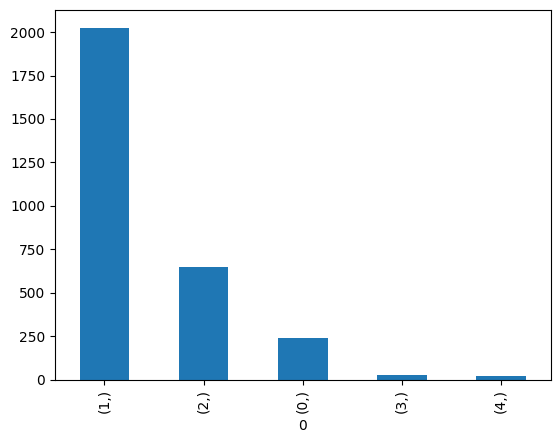

In [18]:
pd.DataFrame([c for c in y_train]).value_counts().plot.bar(x='Emotion', y='Number of Occurrences')

<Axes: xlabel='0'>

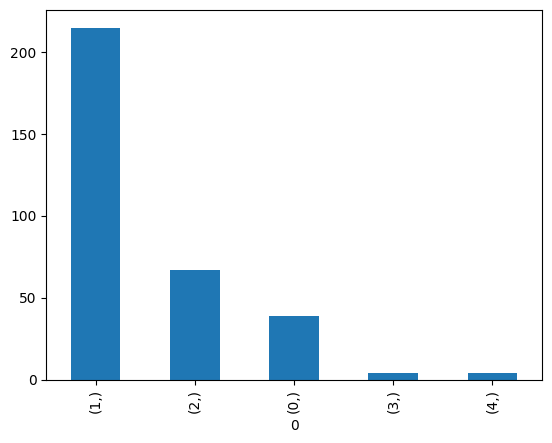

In [19]:
pd.DataFrame([c for c in y_test]).value_counts().plot.bar(x='Emotion', y='Number of Occurrences')

In [28]:
y_train_binary = [0 if i != 1 else 1 for i in y_train ]
y_test_binary = [0 if i != 1 else 1 for i in y_test]

<Axes: xlabel='0'>

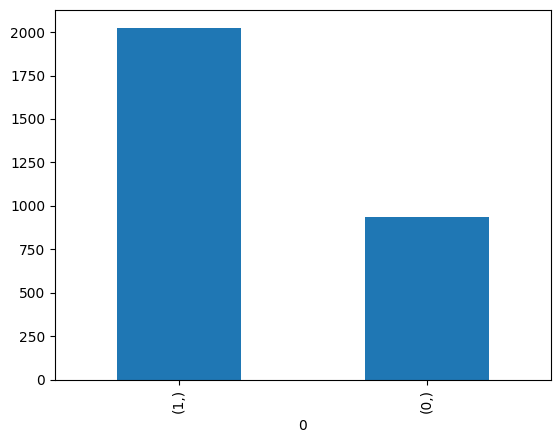

In [21]:
pd.DataFrame([c for c in y_train_binary]).value_counts().plot.bar(x='Emotion', y='Number of Occurrences')

<Axes: xlabel='0'>

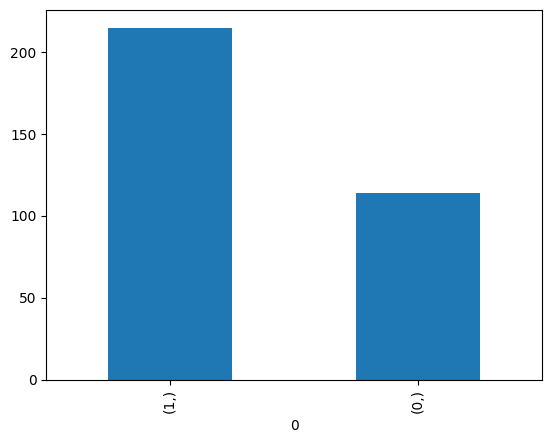

In [22]:
pd.DataFrame([c for c in y_test_binary]).value_counts().plot.bar(x='Emotion', y='Number of Occurrences')

## Training on Binary Split

### SMOTE + Focal Loss (SigmoidFocalCrossEntropy)

In [35]:
y_train_binary = np.array([0 if i != 1 else 1 for i in y_train ])
y_test_binary = np.array([0 if i != 1 else 1 for i in y_test])

In [36]:
smote = SMOTE()

X_train_smote, y_train_smote = smote.fit_resample(
    X_train.reshape((-1, X_train.shape[1] * X_train.shape[2] * X_train.shape[3])),
    y_train_binary
)

X_train_smote = X_train_smote.reshape((-1, X_train.shape[1], X_train.shape[2], X_train.shape[3]))
X_train_smote.shape, y_train_smote.shape

((4052, 200, 200, 3), (4052,))

In [37]:
# Necessary for ResNet Dense Layer
y_train_binary_eye = np.eye(num_classes)[y_train_smote.reshape(-1)]
y_test_binary_eye = np.eye(num_classes)[y_test_binary.reshape(-1)]

In [40]:
X_train_smote.shape, y_train_binary_eye.shape, X_test.shape, y_test_binary_eye.shape

((4052, 200, 200, 3), (4052, 5), (329, 200, 200, 3), (329, 5))

In [43]:
from tensorflow.keras.applications.resnet50 import ResNet50
base_model = ResNet50(weights= None, include_top=False, input_shape=(dimensions[0], dimensions[1], 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

from keras.optimizers import SGD, Adam
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss=SigmoidFocalCrossEntropy(), metrics=['accuracy'])

In [44]:
model.fit(X_train_smote, y_train_binary_eye, epochs=50, batch_size=64)

Epoch 1/50
64/64 [==============================] - 1489s 23s/step - loss: 0.6428 - accuracy: 0.4795
Epoch 2/50
64/64 [==============================] - 1383s 22s/step - loss: 0.3717 - accuracy: 0.5434
Epoch 3/50
64/64 [==============================] - 1379s 22s/step - loss: 0.2253 - accuracy: 0.5874
Epoch 4/50
64/64 [==============================] - 1375s 21s/step - loss: 0.1804 - accuracy: 0.6022
Epoch 5/50
64/64 [==============================] - 1369s 21s/step - loss: 0.1615 - accuracy: 0.6078
Epoch 6/50
64/64 [==============================] - 1382s 22s/step - loss: 0.1400 - accuracy: 0.6488
Epoch 7/50
64/64 [==============================] - 1377s 22s/step - loss: 0.1343 - accuracy: 0.6671
Epoch 8/50
64/64 [==============================] - 1383s 22s/step - loss: 0.1342 - accuracy: 0.6755
Epoch 9/50
64/64 [==============================] - 1402s 22s/step - loss: 0.1190 - accuracy: 0.7093
Epoch 10/50
64/64 [==============================] - 1398s 22s/step - loss: 0.1133 - accura

In [45]:
model.save('./ModelSaves/ResNet_binary_v1')

INFO:tensorflow:Assets written to: ./ModelSaves/ResNet_binary_v1\assets


INFO:tensorflow:Assets written to: ./ModelSaves/ResNet_binary_v1\assets


In [46]:
preds = model.evaluate(X_test, y_test_binary_eye)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

11/11 [==============================] - 26s 2s/step - loss: 0.6589 - accuracy: 0.4924
Loss = 0.6589407920837402
Test Accuracy = 0.49240121245384216


In [47]:
model.fit(X_train_smote, y_train_binary_eye, epochs=25, batch_size=64)

Epoch 1/25
64/64 [==============================] - 1438s 22s/step - loss: 0.0078 - accuracy: 0.9889
Epoch 2/25
64/64 [==============================] - 1421s 22s/step - loss: 0.0162 - accuracy: 0.9766
Epoch 3/25
64/64 [==============================] - 1418s 22s/step - loss: 0.0156 - accuracy: 0.9773
Epoch 4/25
64/64 [==============================] - 1430s 22s/step - loss: 0.0130 - accuracy: 0.9770
Epoch 5/25
64/64 [==============================] - 1431s 22s/step - loss: 0.0116 - accuracy: 0.9832
Epoch 6/25
64/64 [==============================] - 1412s 22s/step - loss: 0.0127 - accuracy: 0.9803
Epoch 7/25
64/64 [==============================] - 1432s 22s/step - loss: 0.0103 - accuracy: 0.9835
Epoch 8/25
64/64 [==============================] - 1427s 22s/step - loss: 0.0115 - accuracy: 0.9810
Epoch 9/25
64/64 [==============================] - 1420s 22s/step - loss: 0.0117 - accuracy: 0.9812
Epoch 10/25
64/64 [==============================] - 1425s 22s/step - loss: 0.0088 - accura

In [48]:
model.save('./ModelSaves/ResNet_binary_v2')

INFO:tensorflow:Assets written to: ./ModelSaves/ResNet_binary_v2\assets


INFO:tensorflow:Assets written to: ./ModelSaves/ResNet_binary_v2\assets


In [49]:
preds = model.evaluate(X_test, y_test_binary_eye)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

11/11 [==============================] - 25s 2s/step - loss: 0.6692 - accuracy: 0.6261
Loss = 0.6691598296165466
Test Accuracy = 0.6261398196220398


In [51]:
model.fit(X_train_smote, y_train_binary_eye, epochs=25, batch_size=64)

Epoch 1/25
64/64 [==============================] - 1488s 23s/step - loss: 0.0113 - accuracy: 0.9835
Epoch 2/25
64/64 [==============================] - 1391s 22s/step - loss: 0.0076 - accuracy: 0.9884
Epoch 3/25
64/64 [==============================] - 1403s 22s/step - loss: 0.0054 - accuracy: 0.9909
Epoch 4/25
64/64 [==============================] - 1391s 22s/step - loss: 0.0071 - accuracy: 0.9899
Epoch 5/25
64/64 [==============================] - 1397s 22s/step - loss: 0.0104 - accuracy: 0.9857
Epoch 6/25
64/64 [==============================] - 1383s 22s/step - loss: 0.0072 - accuracy: 0.9886
Epoch 7/25
64/64 [==============================] - 1461s 23s/step - loss: 0.0115 - accuracy: 0.9854
Epoch 8/25
64/64 [==============================] - 1422s 22s/step - loss: 0.0066 - accuracy: 0.9896
Epoch 9/25
64/64 [==============================] - 1394s 22s/step - loss: 0.0065 - accuracy: 0.9911
Epoch 10/25
64/64 [==============================] - 1385s 22s/step - loss: 0.0074 - accura

In [52]:
model.save('./ModelSaves/ResNet_binary_v3')

INFO:tensorflow:Assets written to: ./ModelSaves/ResNet_binary_v3\assets


INFO:tensorflow:Assets written to: ./ModelSaves/ResNet_binary_v3\assets


In [53]:
preds = model.evaluate(X_test, y_test_binary_eye)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

11/11 [==============================] - 24s 2s/step - loss: 0.8381 - accuracy: 0.5593
Loss = 0.8380724787712097
Test Accuracy = 0.5592705011367798


In [54]:
model.fit(X_train_smote, y_train_binary_eye, epochs=50, batch_size=64)

Epoch 1/50
64/64 [==============================] - 1404s 22s/step - loss: 0.0079 - accuracy: 0.9886
Epoch 2/50
64/64 [==============================] - 1402s 22s/step - loss: 0.0068 - accuracy: 0.9894
Epoch 3/50
64/64 [==============================] - 1462s 23s/step - loss: 0.0074 - accuracy: 0.9901
Epoch 4/50
64/64 [==============================] - 1513s 24s/step - loss: 0.0057 - accuracy: 0.9906
Epoch 5/50
64/64 [==============================] - 1433s 22s/step - loss: 0.0074 - accuracy: 0.9911
Epoch 6/50
64/64 [==============================] - 1438s 22s/step - loss: 0.0098 - accuracy: 0.9867
Epoch 7/50
64/64 [==============================] - 1426s 22s/step - loss: 0.0073 - accuracy: 0.9899
Epoch 8/50
64/64 [==============================] - 1432s 22s/step - loss: 0.0057 - accuracy: 0.9921
Epoch 9/50
64/64 [==============================] - 1417s 22s/step - loss: 0.0037 - accuracy: 0.9931
Epoch 10/50
64/64 [==============================] - 1428s 22s/step - loss: 0.0088 - accura

In [55]:
model.save('./ModelSaves/ResNet_binary_v4')

INFO:tensorflow:Assets written to: ./ModelSaves/ResNet_binary_v4\assets


INFO:tensorflow:Assets written to: ./ModelSaves/ResNet_binary_v4\assets


In [56]:
preds = model.evaluate(X_test, y_test_binary_eye)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

11/11 [==============================] - 25s 2s/step - loss: 0.6230 - accuracy: 0.5866
Loss = 0.6230124235153198
Test Accuracy = 0.5866261124610901


## Altered Dropout

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
base_model = ResNet50(weights= None, include_top=False, input_shape=(dimensions[0], dimensions[1], 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.6)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

from keras.optimizers import SGD, Adam
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss=SigmoidFocalCrossEntropy(), metrics=['accuracy'])

In [ ]:
model.fit(X_train_smote, y_train_binary_eye, epochs=50, batch_size=64)

In [ ]:
model.save('./ModelSaves/ResNet_binary_v5')

In [ ]:
preds = model.evaluate(X_test, y_test_binary_eye)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

## Fear and Happiness

0 = happiness
1 = sadness
2 = fear
3 = disgust
4 = anger

In [67]:
# X_train_df = pd.DataFrame(X_train)
y_train_df = pd.Series(y_train)
# X_test_df = pd.DataFrame(X_test)
y_test_df = pd.Series(y_test)

print(y_train_df.shape, y_test_df.shape)

train_mask = (y_train_df == 0) | (y_train_df == 2)
test_mask = (y_test_df == 0) | (y_test_df == 2)

X_train_fh = X_train[train_mask]
y_train_fh = y_train_df[train_mask]
X_test_fh = X_test[test_mask]
y_test_fh = y_test_df[test_mask]

y_train_fh = y_train_fh.replace(2,1)
y_test_fh = y_test_fh.replace(2,1)

X_train_fh.shape, y_train_fh.shape, X_test_fh.shape, y_test_fh.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape, pd.unique(y_train_fh), pd.unique(y_test_fh)

(2960,) (329,)


((888, 200, 200, 3),
 (888,),
 (106, 200, 200, 3),
 (106,),
 (2960, 200, 200, 3),
 (329, 200, 200, 3),
 (2960,),
 (329,),
 array([0, 1]),
 array([1, 0]))

### SMOTE + Focal Loss (SigmoidFocalCrossEntropy)

In [81]:
smote = SMOTE()

X_train_fh_smote, y_train_fh_smote = smote.fit_resample(
    X_train_fh.reshape((-1, X_train_fh.shape[1] * X_train_fh.shape[2] * X_train_fh.shape[3])),
    y_train_fh
)

X_train_fh_smote = X_train_fh_smote.reshape((-1, X_train_fh.shape[1], X_train_fh.shape[2], X_train_fh.shape[3]))
X_train_fh_smote.shape, y_train_fh_smote.shape

((1296, 200, 200, 3), (1296,))

In [86]:
# Necessary for ResNet Dense Layer
y_train_fh_smote_eye = np.eye(num_classes)[y_train_fh_smote.to_numpy().reshape(-1)]
y_test_fh_eye = np.eye(num_classes)[y_test_fh.to_numpy().reshape(-1)]

In [87]:
X_train_fh_smote.shape, y_train_fh_smote_eye.shape, X_test_fh.shape, y0_test_fh_eye.shape

((1296, 200, 200, 3), (1296, 5), (106, 200, 200, 3), (106, 5))

In [88]:
from tensorflow.keras.applications.resnet50 import ResNet50
base_model = ResNet50(weights= None, include_top=False, input_shape=(dimensions[0], dimensions[1], 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

from keras.optimizers import SGD, Adam
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss=SigmoidFocalCrossEntropy(), metrics=['accuracy'])

In [89]:
model.fit(X_train_fh_smote, y_train_fh_smote_eye, epochs=50, batch_size=64)

Epoch 1/50
21/21 [==============================] - 537s 25s/step - loss: 0.8749 - accuracy: 0.4120
Epoch 2/50
21/21 [==============================] - 465s 22s/step - loss: 0.5509 - accuracy: 0.5386
Epoch 3/50
21/21 [==============================] - 477s 23s/step - loss: 0.3955 - accuracy: 0.5872
Epoch 4/50
21/21 [==============================] - 468s 22s/step - loss: 0.3243 - accuracy: 0.6435
Epoch 5/50
21/21 [==============================] - 503s 24s/step - loss: 0.2552 - accuracy: 0.6196
Epoch 6/50
21/21 [==============================] - 472s 22s/step - loss: 0.2025 - accuracy: 0.7060
Epoch 7/50
21/21 [==============================] - 470s 22s/step - loss: 0.1732 - accuracy: 0.7230
Epoch 8/50
21/21 [==============================] - 469s 22s/step - loss: 0.1517 - accuracy: 0.7515
Epoch 9/50
21/21 [==============================] - 463s 22s/step - loss: 0.1225 - accuracy: 0.7901
Epoch 10/50
21/21 [==============================] - 467s 22s/step - loss: 0.1295 - accuracy: 0.8071

In [90]:
model.save('./ModelSaves/ResNet_binary_fh_v1')

INFO:tensorflow:Assets written to: ./ModelSaves/ResNet_binary_fh_v1\assets


INFO:tensorflow:Assets written to: ./ModelSaves/ResNet_binary_fh_v1\assets


In [91]:
preds = model.evaluate(X_test_fh, y_test_fh_eye)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 10s 2s/step - loss: 0.6721 - accuracy: 0.6321
Loss = 0.672052800655365
Test Accuracy = 0.6320754885673523


In [92]:
model.fit(X_train_fh_smote, y_train_fh_smote_eye, epochs=25, batch_size=64)

Epoch 1/25
21/21 [==============================] - 507s 24s/step - loss: 0.0066 - accuracy: 0.9946
Epoch 2/25
21/21 [==============================] - 481s 23s/step - loss: 0.0049 - accuracy: 0.9923
Epoch 3/25
21/21 [==============================] - 462s 22s/step - loss: 0.0059 - accuracy: 0.9946
Epoch 4/25
21/21 [==============================] - 472s 22s/step - loss: 0.0092 - accuracy: 0.9900
Epoch 5/25
21/21 [==============================] - 457s 22s/step - loss: 0.0172 - accuracy: 0.9769
Epoch 6/25
21/21 [==============================] - 479s 23s/step - loss: 0.0123 - accuracy: 0.9823
Epoch 7/25
21/21 [==============================] - 467s 22s/step - loss: 0.0141 - accuracy: 0.9799
Epoch 8/25
21/21 [==============================] - 494s 24s/step - loss: 0.0154 - accuracy: 0.9730
Epoch 9/25
21/21 [==============================] - 490s 23s/step - loss: 0.0140 - accuracy: 0.9799
Epoch 10/25
21/21 [==============================] - 479s 23s/step - loss: 0.0088 - accuracy: 0.9877

In [93]:
model.save('./ModelSaves/ResNet_binary_fh_v2')

INFO:tensorflow:Assets written to: ./ModelSaves/ResNet_binary_fh_v2\assets


INFO:tensorflow:Assets written to: ./ModelSaves/ResNet_binary_fh_v2\assets


In [94]:
preds = model.evaluate(X_test_fh, y_test_fh_eye)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 9s 2s/step - loss: 0.7347 - accuracy: 0.6509
Loss = 0.7347078919410706
Test Accuracy = 0.650943398475647


In [95]:
model.fit(X_train_fh_smote, y_train_fh_smote_eye, epochs=25, batch_size=64)

Epoch 1/25
21/21 [==============================] - 492s 23s/step - loss: 0.0068 - accuracy: 0.9892
Epoch 2/25
21/21 [==============================] - 548s 26s/step - loss: 0.0053 - accuracy: 0.9923
Epoch 3/25
21/21 [==============================] - 543s 26s/step - loss: 0.0082 - accuracy: 0.9923
Epoch 4/25
21/21 [==============================] - 519s 24s/step - loss: 0.0099 - accuracy: 0.9869
Epoch 5/25
21/21 [==============================] - 481s 23s/step - loss: 0.0061 - accuracy: 0.9900
Epoch 6/25
21/21 [==============================] - 487s 23s/step - loss: 0.0071 - accuracy: 0.9923
Epoch 7/25
21/21 [==============================] - 507s 24s/step - loss: 0.0047 - accuracy: 0.9907
Epoch 8/25
21/21 [==============================] - 469s 22s/step - loss: 0.0044 - accuracy: 0.9946
Epoch 9/25
21/21 [==============================] - 522s 25s/step - loss: 0.0037 - accuracy: 0.9946
Epoch 10/25
21/21 [==============================] - 482s 23s/step - loss: 0.0077 - accuracy: 0.9892

In [96]:
model.save('./ModelSaves/ResNet_binary_fh_v3')

INFO:tensorflow:Assets written to: ./ModelSaves/ResNet_binary_fh_v3\assets


INFO:tensorflow:Assets written to: ./ModelSaves/ResNet_binary_fh_v3\assets


In [97]:
preds = model.evaluate(X_test_fh, y_test_fh_eye)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 9s 2s/step - loss: 0.8214 - accuracy: 0.6509
Loss = 0.8213719725608826
Test Accuracy = 0.650943398475647
